#FRED Economic Data Project: ETL#

The goal of this notebook is to set out the steps for extracting, transforming and loading economic data from the Federal Reserve Economic Data (FRED) website to create a usable dataset for analysis.


In [1]:
# Install required libraries
# Update SSL certificates due to possible conflicts with modules
!pip3 install --upgrade certifi
!pip3 install python-certifi-win32
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install plotly --upgrade
!pip3 install plotly.express
!pip3 install fredapi 



     -------------------------------------- 162.5/162.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: certifi
    Found existing installation: certifi 2023.7.22
    Uninstalling certifi-2023.7.22:
      Successfully uninstalled certifi-2023.7.22


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires chardet<4,>=3.0.2, which is not installed.
selenium 4.11.2 requires urllib3[socks]<3,>=1.26, but you have urllib3 1.25.11 which is incompatible.
jupyterlab-server 2.19.0 requires requests>=2.28, but you have requests 2.23.0 which is incompatible.


     --------------------------------------- 15.6/15.6 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.17.0
    Uninstalling plotly-5.17.0:
      Successfully uninstalled plotly-5.17.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from fredapi import Fred
import getpass

# Set design style from matplotlib.pyplot
plt.style.use("fivethirtyeight")

# Set max columns for pandas
pd.set_option("display.max_rows", None)
pd.options.display.max_columns = 500

# Define a color palette for use from the matplotlib.plotly style
color_palette = plt.rcParams["axes.prop_cycle"].by_key()[
    "color"
]  # Import libraries for working with datasets

In [3]:
# Create a key object to access the FRED API
fred_api_key = getpass.getpass("Enter FRED API key: ")

# Create the fred_api Fred object # 

Create a callable connection to the FRED API service so that we can search and ull data directly from FRED.

In [4]:
# Create a connection object using fred_api.Fred()
Fred_conn = Fred(api_key=fred_api_key)

# Search FRED API for relevant economic data #
For this project, we'll be looking at trends in the global prices of various edible oils.
FRED has data on the global prices for:
- Olive Oil
- Palm Oil
- Rapeseed Oil
- Soybean Oil
- Sunflower Oil

We want to know how prices have changed over the years, and see if there has been any major coincidental trends with different oils.

In [5]:
# Search FRED data via the Fred connection object
# Here we will look for the Global price of different food oils.

# Olive Oil
Fred_conn.search("POLVOILUSDM")

# Sunflower Oil
Fred_conn.search("PSUNOUSDM")

# Palm OIl
Fred_conn.search("PPOILUSDM")

# Rapeseed Oil
Fred_conn.search("PROILUSDM")

# Soybean Oil
Fred_conn.search("PSOILUSDM")

,frequency,frequency_short,id,last_updated,notes,observation_end,observation_start,popularity,realtime_end,realtime_start,seasonal_adjustment,seasonal_adjustment_short,title,units,units_short
series id,,,,,,,,,,,,,,,
PSOILUSDM,Monthly,M,PSOILUSDM,2023-12-18 19:04:10-06:00,Value represents the benchmark prices which ar...,2023-11-01,1990-01-01,35,2024-01-05,2024-01-05,Not Seasonally Adjusted,NSA,Global price of Soybeans Oil,U.S. Dollars per Metric Ton,U.S. $ per Metric Ton


In [6]:
# Create list to store series dataframes
glob_oil_prices = []

# Create a loop to iterate through each series and pull data for each class of oil
for s in ["POLVOILUSDM", "PSUNOUSDM", "PPOILUSDM", "PROILUSDM", "PSOILUSDM"]:
    results = Fred_conn.get_series(s)
    # Rename series values to respective id
    results = results.to_frame(name=s)
    # Append to list
    glob_oil_prices.append(results)

In [7]:
glob_oil_prices[4].head(10)

,PSOILUSDM
1980-01-01,NaN
1980-02-01,NaN
1980-03-01,NaN
1980-04-01,NaN
1980-05-01,NaN
1980-06-01,NaN
1980-07-01,NaN
1980-08-01,NaN
1980-09-01,NaN
1980-10-01,NaN


# Join Series Data to make one large queriable data frame #

Now that we have all of our series data stored in a single list, we should compose a single data frame using each series.

In [8]:
# Concatenate listed series data into a single dataframe
glob_oil_prices_df = pd.concat(glob_oil_prices, axis=1)

# Rename the index to 'date'
glob_oil_prices_df.index.rename("date", inplace=True)
glob_oil_prices_df.head()

,POLVOILUSDM,PSUNOUSDM,PPOILUSDM,PROILUSDM,PSOILUSDM
date,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN,NaN,NaN
1980-03-01,NaN,NaN,NaN,NaN,NaN
1980-04-01,NaN,NaN,NaN,NaN,NaN
1980-05-01,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

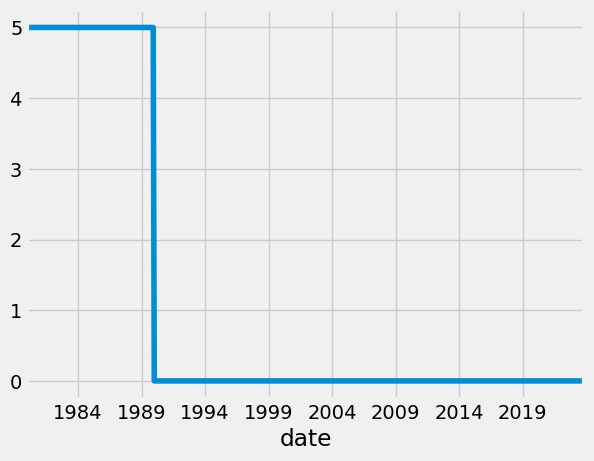

In [9]:
# Visualize distribution of Null Values
glob_oil_prices_df.isna().sum(axis=1).plot()

In [10]:
# We don't seem to have data from 1980 to 1990 for any of the observed oil prices, so we can safely drop the null values.
glob_oil_prices_df.dropna(inplace=True)
glob_oil_prices_df.head()

,POLVOILUSDM,PSUNOUSDM,PPOILUSDM,PROILUSDM,PSOILUSDM
date,,,,,
1990-01-01,2972.682,588.036232,230.555951,440.95,418.657338
1990-02-01,3052.710,608.475000,223.945027,422.29,438.719380
1990-03-01,2925.144,618.075758,236.340509,412.77,487.221020
1990-04-01,2945.970,609.507937,220.639566,428.80,498.244120
1990-05-01,3021.102,621.768116,232.208681,444.77,526.904180


In [11]:
# For the sake of readability, we will change the value titles to be clearer

# Create dictionary to make renaming columns easier
new_column_titles = {
    "POLVOILUSDM": "Olive Oil",
    "PSUNOUSDM": "Sunflower Oil",
    "PPOILUSDM": "Palm Oil",
    "PROILUSDM": "Rapeseed Oil",
    "PSOILUSDM": "Soybean Oil",
}

# Rename columns in the dataframe

glob_oil_prices_df.rename(columns=new_column_titles, inplace=True)
glob_oil_prices_df.head()

,Olive Oil,Sunflower Oil,Palm Oil,Rapeseed Oil,Soybean Oil
date,,,,,
1990-01-01,2972.682,588.036232,230.555951,440.95,418.657338
1990-02-01,3052.710,608.475000,223.945027,422.29,438.719380
1990-03-01,2925.144,618.075758,236.340509,412.77,487.221020
1990-04-01,2945.970,609.507937,220.639566,428.80,498.244120
1990-05-01,3021.102,621.768116,232.208681,444.77,526.904180


In [12]:
# We might also want to know the percent of change from month to month of oil prices

# Sort the DataFrame by 'item' and 'date' to ensure it's in the correct order
glob_oil_prices_df = glob_oil_prices_df.sort_values(by=["date"])

# Calculate the price increase factor on a monthly basis

# Calculate the price change factor for each price column
glob_oil_prices_df["Olive Oil Change %"] = glob_oil_prices_df["Olive Oil"].pct_change()
glob_oil_prices_df["Sunflower Oil Change %"] = glob_oil_prices_df[
    "Sunflower Oil"
].pct_change()
glob_oil_prices_df["Palm Oil Change %"] = glob_oil_prices_df["Palm Oil"].pct_change()
glob_oil_prices_df["Rapeseed Oil Change %"] = glob_oil_prices_df[
    "Rapeseed Oil"
].pct_change()
glob_oil_prices_df["Soybean Oil Change %"] = glob_oil_prices_df[
    "Soybean Oil"
].pct_change()

glob_oil_prices_df.head()

,Olive Oil,Sunflower Oil,Palm Oil,Rapeseed Oil,Soybean Oil,Olive Oil Change %,Sunflower Oil Change %,Palm Oil Change %,Rapeseed Oil Change %,Soybean Oil Change %
date,,,,,,,,,,
1990-01-01,2972.682,588.036232,230.555951,440.95,418.657338,NaN,NaN,NaN,NaN,NaN
1990-02-01,3052.710,608.475000,223.945027,422.29,438.719380,0.026921,0.034758,-0.028674,-0.042318,0.047920
1990-03-01,2925.144,618.075758,236.340509,412.77,487.221020,-0.041788,0.015778,0.055351,-0.022544,0.110553
1990-04-01,2945.970,609.507937,220.639566,428.80,498.244120,0.007120,-0.013862,-0.066434,0.038835,0.022624
1990-05-01,3021.102,621.768116,232.208681,444.77,526.904180,0.025503,0.020115,0.052434,0.037243,0.057522


In [13]:
# Round all values to 2 decimal places

glob_oil_prices_2 = glob_oil_prices_df[
    [
        "Olive Oil",
        "Sunflower Oil",
        "Palm Oil",
        "Rapeseed Oil",
        "Soybean Oil",
        "Olive Oil Change %",
        "Sunflower Oil Change %",
        "Palm Oil Change %",
        "Rapeseed Oil Change %",
        "Soybean Oil Change %",
    ]
].applymap(lambda x: round(x, 2))

glob_oil_prices_2.head(10)

,Olive Oil,Sunflower Oil,Palm Oil,Rapeseed Oil,Soybean Oil,Olive Oil Change %,Sunflower Oil Change %,Palm Oil Change %,Rapeseed Oil Change %,Soybean Oil Change %
date,,,,,,,,,,
1990-01-01,2972.68,588.04,230.56,440.95,418.66,NaN,NaN,NaN,NaN,NaN
1990-02-01,3052.71,608.48,223.95,422.29,438.72,0.03,0.03,-0.03,-0.04,0.05
1990-03-01,2925.14,618.08,236.34,412.77,487.22,-0.04,0.02,0.06,-0.02,0.11
1990-04-01,2945.97,609.51,220.64,428.80,498.24,0.01,-0.01,-0.07,0.04,0.02
1990-05-01,3021.10,621.77,232.21,444.77,526.90,0.03,0.02,0.05,0.04,0.06
1990-06-01,3074.49,612.37,224.77,430.43,531.75,0.02,-0.02,-0.03,-0.03,0.01
1990-07-01,3252.20,589.29,230.56,435.43,530.65,0.06,-0.04,0.03,0.01,-0.00
1990-08-01,3416.71,581.15,240.47,421.39,536.82,0.05,-0.01,0.04,-0.03,0.01
1990-09-01,3383.62,580.13,234.69,422.95,524.48,-0.01,-0.00,-0.02,0.00,-0.02


# Exploratory Data Analysis: Visualizing data with Plotly #

Now that we have our data cleaned and joined, we can do a quick visualization to identify patterns in the prices of oils from January 1990 to present.



In [14]:
# Generate a basic line plot of global prices for oils selected.
all_years_plt = px.line(
    glob_oil_prices_2[
        ["Olive Oil", "Palm Oil", "Rapeseed Oil", "Soybean Oil", "Sunflower Oil"]
    ]
)
all_years_plt

In [15]:
# The data shows a sudden uptick in the price of Olive Oil around mid 2022.
# We may want to look a bit more closely at the trends in prices within the last 2 or 3 years.

# Import datetime module
from datetime import datetime

# Get current date
current_date = datetime.now()

# Filter dates from January 2020 to present
glob_oil_prices_2020 = glob_oil_prices_2["2020-01-01":current_date]
glob_oil_prices_2020.head()

,Olive Oil,Sunflower Oil,Palm Oil,Rapeseed Oil,Soybean Oil,Olive Oil Change %,Sunflower Oil Change %,Palm Oil Change %,Rapeseed Oil Change %,Soybean Oil Change %
date,,,,,,,,,,
2020-01-01,2687.32,1000.22,726.59,940.32,728.03,-0.06,0.04,0.06,0.02,0.01
2020-02-01,2737.94,913.68,642.25,890.04,666.86,0.02,-0.09,-0.12,-0.05,-0.08
2020-03-01,2796.26,847.00,557.90,793.11,592.93,0.02,-0.07,-0.13,-0.11,-0.11
2020-04-01,2775.09,878.25,518.47,759.34,577.67,-0.01,0.04,-0.07,-0.04,-0.03
2020-05-01,2754.38,900.05,498.48,792.73,585.39,-0.01,0.02,-0.04,0.04,0.01


In [16]:
# Visualize the filtered data using a stacked bar graph
oil_prices_2020_to_present = px.bar(
    glob_oil_prices_2020[
        ["Olive Oil", "Palm Oil", "Rapeseed Oil", "Soybean Oil", "Sunflower Oil"]
    ]
)

# Format the visual
# Set the title for the whole plot
oil_prices_2020_to_present.update_layout(
    title_text="Global Price of Edible Oils January 2020 to Present"
)
oil_prices_2020_to_present.update_xaxes(title_text="Date")
oil_prices_2020_to_present.update_yaxes(title_text="Price USD/Metric Tonne")

In [17]:
# Reformat the plot visual for clarity
# Create a stacked area chart
fig = px.bar(
    glob_oil_prices_2020[
        [
            "Olive Oil Change %",
            "Palm Oil Change %",
            "Rapeseed Oil Change %",
            "Soybean Oil Change %",
            "Sunflower Oil Change %",
        ]
    ],
    title="Edible Oil Price Fluctuation 2020-Present",
)

# Label axes
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Percent Fluctuation")

# Set the y-axis scale to %
fig.update_layout(yaxis_tickformat=".0%")

# Show the plot
fig.show()

# End of Exploratory Data Analysis #

With this we have:
- identified important trends in the data
- isolated a subset of the data for investigation
- created a visualization of the percentage of fluctuation on a monthly basis for each of the edible oils selected.

For the next step, we will convert this notebook in to Python Script to run in Microsoft PowerBI.
